In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numba import jit
import datetime

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
sessions = pd.read_csv('c:/users/matt/desktop/poker paper/sessions ev prep.csv')
#ephemerals = pd.read_csv('c:/users/matt/desktop/poker paper/suckers.csv')

sessions = sessions.drop('Unnamed: 0', 1).drop(sessions.loc[:, 'Time^2':], 1)
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])

#ephemerals = ephemerals.drop('Unnamed: 0', 1).drop(ephemerals.loc[:, 'Time^2':], 1)
#ephemerals['Session Start'] = pd.to_datetime(ephemerals['Session Start'])

#ephemerals['wage'] = (ephemerals['My C Won']/ephemerals['Minutes'])*60
sessions['wage'] = (sessions['My C Won']/sessions['Minutes'])*60

sessions['BB EV'] = (sessions['BB vs SB call won (bb)']/sessions['BB vs SB call cnt']).fillna(0)

In [8]:
ephemerals  = sessions[sessions['ephemeral'] == 1]

sessions = sessions[sessions['ephemeral'] != 1]

In [9]:
sessionskmc = sessions[sessions['k means'] == 1]
sessionskmcNOT = sessions[sessions['k means'] != 1]

sessionstc = sessions[sessions['t_cluster'] == 1]
sessionstcNOT = sessions[sessions['t_cluster'] != 1]

sessionsagglo = sessions[sessions['agglo'] == 1]
sessionsaggloNOT = sessions[sessions['agglo'] != 1]

In [15]:
def make_hourly_daily(sess):
    hourly = sess.copy(deep=True)
    hourly = hourly.drop(sess.loc[:, 'Total AF':'during/after'], 1)\
                     .drop(sess.loc[:, 'Time':'Time'], 1)#\
                    #.drop(sess.loc[:, 'Fold BB v SB':'WTSD %'], 1)\

    daily = sess.copy(deep=True)
    daily = daily.drop(sess.loc[:, 'Total AF':'during/after'], 1)\
                     .drop(sess.loc[:, 'Time':'Time'], 1)#\
                    #.drop(sess.loc[:, 'Fold BB v SB':'WTSD %'], 1)\

    hourly = hourly.set_index('Session Start')
    daily = daily.set_index('Session Start')

    daily_avg = daily.groupby(pd.TimeGrouper('1440Min')).mean()
    hourly_avg = hourly.groupby(pd.TimeGrouper('60Min')).mean()
    daily = daily.groupby(pd.TimeGrouper('1440Min')).sum()
    hourly = hourly.groupby(pd.TimeGrouper('60Min')).sum()

    hourly.loc[:, 'Treat':'11PM'] = hourly_avg.loc[:, 'Treat':]
    daily.loc[:, 'Treat':'11PM'] = daily_avg.loc[:, 'Treat':]

    hourly['wage'] = hourly_avg['wage']
    daily['wage'] = daily_avg['wage']
    hourly['Minutes avg'] = hourly_avg['Minutes']
    daily['Minutes avg'] = daily_avg['Minutes']
    hourly['Hands avg'] = hourly_avg['Hands']
    daily['Hands avg'] = daily_avg['Hands']
    hourly['My C Won avg'] = hourly_avg['My C Won']
    daily['My C Won avg'] = daily_avg['My C Won']
    hourly['My C Rake Share avg'] = hourly_avg['My C Rake Share']
    daily['My C Rake Share avg'] = daily_avg['My C Rake Share']
    
    daily['BB EV'] = (daily['BB vs SB call won (bb)']/daily['BB vs SB call cnt']).fillna(0)
    hourly['BB EV'] = (hourly['BB vs SB call won (bb)']/hourly['BB vs SB call cnt']).fillna(0)
    
    hourly = hourly.fillna(0)
    daily = daily.fillna(0)
    
    return hourly, daily

In [16]:
hourly, daily = make_hourly_daily(sessions)
hourlykmc, dailykmc = make_hourly_daily(sessionskmc)
hourlykmcnot, dailykmcnot = make_hourly_daily(sessionskmcNOT)
hourlytc, dailytc = make_hourly_daily(sessionstc)
hourlytcnot, dailytcnot = make_hourly_daily(sessionstcNOT)
hourlyagglo, dailyagglo = make_hourly_daily(sessionsagglo)
hourlyagglonot, dailyagglonot = make_hourly_daily(sessionsaggloNOT)

In [17]:
hourlyeph, dailyeph = make_hourly_daily(ephemerals)

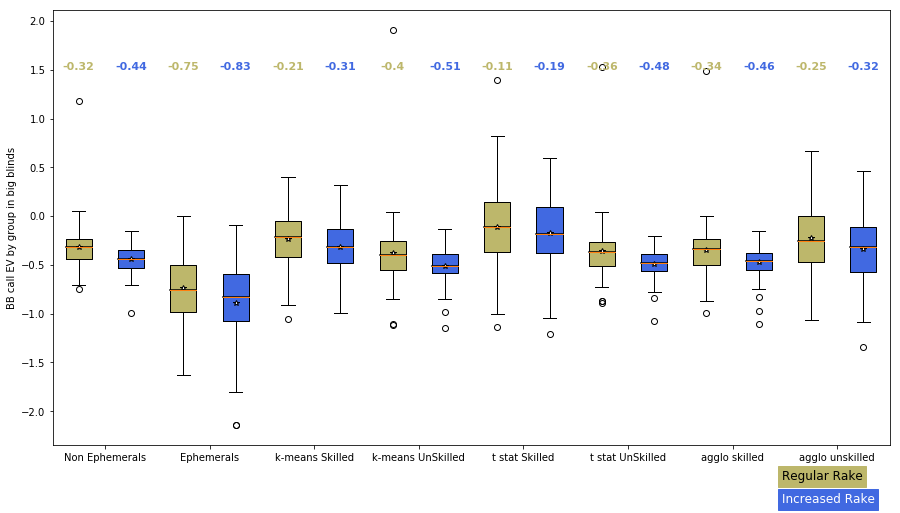

In [21]:
xsize=15
ysize=8
fig, ax1 = plt.subplots(figsize=(xsize, ysize))

data = [daily[daily['Treat'] == 0]['BB EV'], 
        daily[daily['Treat'] != 0]['BB EV'],
        dailyeph[dailyeph['Treat'] == 0]['BB EV'],
        dailyeph[dailyeph['Treat'] != 0]['BB EV'],
        dailykmc[dailykmc['Treat'] == 0]['BB EV'],
        dailykmc[dailykmc['Treat'] != 0]['BB EV'],
        dailykmcnot[dailykmcnot['Treat'] == 0]['BB EV'],
        dailykmcnot[dailykmcnot['Treat'] != 0]['BB EV'],
        dailytc[dailytc['Treat'] == 0]['BB EV'],
        dailytc[dailytc['Treat'] != 0]['BB EV'],
        dailytcnot[dailytcnot['Treat'] == 0]['BB EV'],
        dailytcnot[dailytcnot['Treat'] != 0]['BB EV'],
        dailyagglo[dailyagglo['Treat'] == 0]['BB EV'],
        dailyagglo[dailyagglo['Treat'] != 0]['BB EV'],
        dailyagglonot[dailyagglonot['Treat'] == 0]['BB EV'],
        dailyagglonot[dailyagglonot['Treat'] != 0]['BB EV']]

bp = plt.boxplot(data)

ax1.set_ylabel('BB call EV by group in big blinds')
ax1.set_xticklabels(['Non Ephemerals', 'Ephemerals', 'k-means Skilled', 'k-means UnSkilled',
                     't stat Skilled', 't stat UnSkilled', 'agglo skilled', 'agglo unskilled'])
ax1.set_xticks([1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5])

boxColors = ['darkkhaki', 'royalblue']
medians = list(range(len(data)))
for i in range(len(data)):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = plt.Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
             color='w', marker='*', markeredgecolor='k')
    

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(len(data)) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick in range(len(data)):
    k = tick % 2
    ax1.text(pos[tick], 1.5, upperLabels[tick],
             horizontalalignment='center', size=11, weight=weights[k],
             color=boxColors[k])
    

# Finally, add a basic legend
plt.figtext(0.80, 0.065, 'Regular Rake',
            backgroundcolor=boxColors[0], color='black', weight='roman',
            size='12')
plt.figtext(0.80, 0.025, 'Increased Rake',
            backgroundcolor=boxColors[1],
            color='white', weight='roman', size=12)

plt.show()